In [64]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sympy
from sympy import Symbol, sin, sqrt
from scipy.interpolate import Rbf
from scipy import interpolate
from scipy import integrate
import scipy

# Piecewise-constant approximation of sin(x)

The following class computes a piecewise-constant approximation of 
$f(x) = \sin{x}$
. The approximation is computed using an L2 projection (Galerkin projection) of $\sin{x}$ onto the constant vector space for each element. [This is overkill for a constant approximation, but details on the general form can be found here.](http://hplgit.github.io/num-methods-for-PDEs/doc/pub/approx/html/._approx003.html)


It also computes the L2 error, defined as
$||f_{exact} - f_{approximate} ||_2 = \sqrt{\frac{\int{(f_{exact} - f_{approximate})^2\ dV} }{\int{dV}} }$

Despite the approximation being discontinuous, it is integrable, so we compute it by summing the integral defined on each element. This gives an unambigious notion of the quality of the function approximation.

In [76]:
class PiecewiseConstantApproximation:
    def __init__(self, Ncells):
        self.Ncells = Ncells
        self.dx = 2.0*np.pi / Ncells
        self.centroids = np.linspace(self.dx/2, 2.0*np.pi-self.dx/2, self.Ncells)
        self.cellaverages = np.zeros(self.Ncells)
        x = Symbol('x')
        for i in range(self.centroids.size):
            A = self.dx
            xl = i*self.dx
            xr = xl+self.dx
            b = sympy.integrate(sin(x),(x,xl,xr))
            self.cellaverages[i] = b / A
    def plot(self):
        plt.figure()
        plt.plot(self.centroids, self.cellaverages,'o')
        for i in range(self.centroids.size):
            plt.plot([self.centroids[i]-self.dx/2, self.centroids[i]+self.dx/2],
                     [self.cellaverages[i],self.cellaverages[i]],'-',color='green')
        xx = np.linspace(0,2.0*np.pi,100)
        plt.plot(xx, np.sin(xx))
        plt.xlabel('x')
        plt.show()
    def plot_with_interpolation(self, interp, interpname):
        plt.figure()
        plt.plot(self.centroids, self.cellaverages,'o')
        for i in range(self.centroids.size):
            plt.plot([self.centroids[i]-self.dx/2, self.centroids[i]+self.dx/2],
                     [self.cellaverages[i],self.cellaverages[i]],'-',color='green')
        xx = np.linspace(0,2.0*np.pi,100)
        plt.plot(xx, np.sin(xx),color='orange', label="sin(x)")
        plt.plot(xx, interp(xx), color='blue', label=interpname)
        plt.xlabel('x')
        plt.legend()
        plt.show()
    def l2error(self):
        x = Symbol('x')
        global_error = 0.0
        for i in range(self.centroids.size):
            xl = i*self.dx
            xr = xl+self.dx
            global_error += sympy.integrate( (sin(x) - self.cellaverages[i])**2, (x,xl,xr))
        return sqrt(global_error/(2.0*np.pi))
    def get_solution(self):
        return self.centroids, self.cellaverages
    def ncells(self):
        return self.Ncells

## Visualizing the approximation

Here we plot the piecewise constant approximation with 5, 10, and 20 cells. Clearly the approximation is getting better in some sense as we increase the resolution.

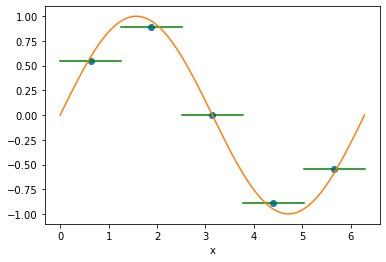

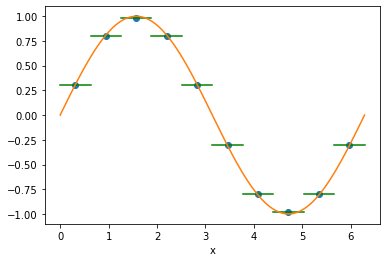

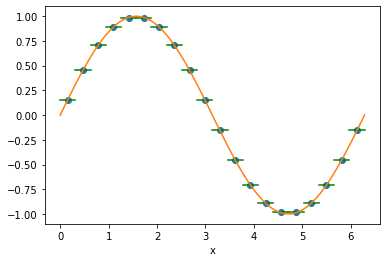

In [77]:
ncells = np.array([5,10,20])
approximation = []
for ncell in ncells:
    approximation.append(PiecewiseConstantApproximation(ncell))
    approximation[-1].plot()

## Quantifying the approximation

Next we compute the L2 error of the approximation as defined above. Notice the slope of this error is -1; the integrated error of the piecewise constant approximation is 1st order accurate.

N cells:  5  L2 error:  0.24985976058243106
N cells:  10  L2 error:  0.12741426671476266
N cells:  20  L2 error:  0.06402210512431501


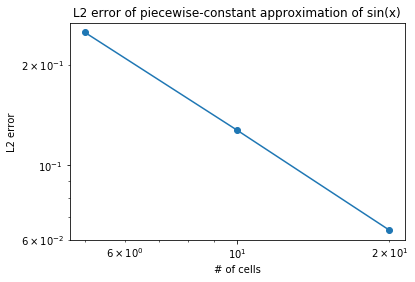

In [78]:
errors = np.zeros(ncells.size)
piecewise_constants = []
for idx, approx in enumerate(approximation):
    errors[idx] = approx.l2error()
    print("N cells: ", approx.Ncells, " L2 error: ", errors[idx])
    
plt.loglog(ncells, errors,'-o')
plt.title("L2 error of piecewise-constant approximation of sin(x)")
plt.xlabel('# of cells')
plt.ylabel('L2 error')
plt.show()

## Interpolating

Now the fun part. As an input we take the cell-centered values of the piecewise linear approximation and throw away all other data. We no longer "know" that the original function was $\sin(x)$. This is the equivalent task of interpolating values from an arbitrary CFD flow field (or any other scattered data approximation problem).

The RBF interpolation gives us a nice smooth reconstruction which we can also use to compute an error of the function approximation in the same manner.

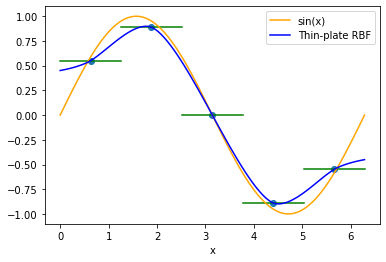

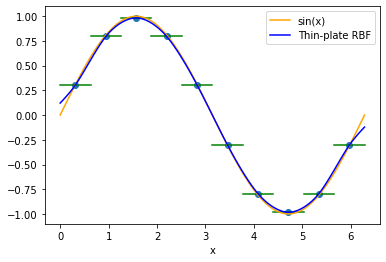

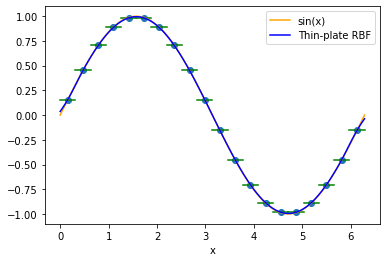

In [79]:
rbf_errors = np.zeros(ncells.size)
for idx, approx in enumerate(approximation):
    x,y = approx.get_solution()
    thinplate = Rbf(x, y, function='thin_plate')
    
    approx.plot_with_interpolation(thinplate, "Thin-plate RBF")
    integrand = lambda x: np.power(np.sin(x) - thinplate(x), 2.0) # integrand is the squared error
    squared_error = scipy.integrate.quadrature(integrand, 0.0, 2.0*np.pi, maxiter=200) # adaptive quadrature
    rbf_errors[idx] = np.sqrt(squared_error[0] / (2.0*np.pi))


## Comparing the error of the two approximations

Plotting the error of the original and reconstructed approximations, we have the non-obvious result that we are able to create a better function approximation using only the low order data and no information about the original function.

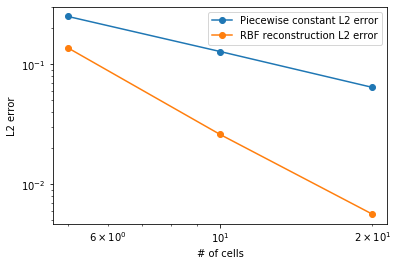

In [80]:
plt.loglog(ncells, errors,'-o', label='Piecewise constant L2 error')
plt.loglog(ncells, rbf_errors,'-o', label='RBF reconstruction L2 error')
plt.xlabel('# of cells')
plt.ylabel('L2 error')
plt.legend()
plt.show()

## Yadda yadda yadda

The same basic idea still holds for piecewise linear or more accurate approximations. You can do better than linear reconstructions. A lot more can be said on this subject.

[A Practical Guide to Radial Basis Functions](https://num.math.uni-goettingen.de/schaback/teaching/sc.pdf) by Schaback is a nice easy read on this class of interpolations which have a lot of nice properties, particularly their straightforward extension to arbitrary dimension.